# Galaxies: An interactive graduate course

## Chapter 6: Gas accretion and cooling

#### (c) Benedikt Diemer, University of Maryland

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

We first define a few useful constants for this unit. The symbol $\mu$ refers to the mean particle mass in units of proton masses. For an ionized gas of primordial composition, this is about 0.59. However, we will often use $n = n_{\rm H}$ as the number density of hydrogen nuclei, in which case the conversion is $\rho = 1.4 n_{\rm H}$ because of the extra weight of Helium.

In [2]:
mu_ion = 0.59
mu_h = 1.4

h = cmn.cosmo.h
Om0 = cmn.cosmo.Om0
Ob0 = cmn.cosmo.Ob0
baryon_frac = Ob0 / Om0

### 6.1) Accretion shocks and the virial temperature

We use Colossus to convert spherical overdensity radii and masses to work out the virial velocity of a MW-sized halo.

In [3]:
from colossus.utils import constants
from colossus.halo import mass_so

z = 0.0
Mvir = 1E12

Mvir_h = Mvir * h
Rvir_h = mass_so.M_to_R(Mvir_h, z, 'vir')
Vvir_M12 = np.sqrt(constants.G * Mvir_h / Rvir_h)

print('Vvir = %.2e km/s (Mvir / 1E12 Msun)^1/3' % Vvir_M12)

Vvir = 1.28e+02 km/s (Mvir / 1E12 Msun)^1/3


Similarly, we can work out the shock temperature as a function of virial velocity and halo mass:

In [4]:
Tvir_V100 = mu_ion * constants.M_PROTON / constants.KB / 3 * (100.0 * 1E5)**2

print('Tvir = %.2e (Vvir / 100 km/s)^2' % Tvir_V100)

Tvir_M12 = Tvir_V100 * (Vvir_M12 / 100.0)**2

print('Tvir = %.2e (Mvir / 1E12 Msun)^2/3' % Tvir_M12)

Tvir = 2.38e+05 (Vvir / 100 km/s)^2
Tvir = 3.89e+05 (Mvir / 1E12 Msun)^2/3


### 6.2) Cooling

#### 6.2.1) Cooling mechanisms and rates

Let's plot the cooling curves of [Plöckinger & Schaye 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.497.4857P/abstract) as a function of temperature, both for different metallicities and different densities. The full tables come as a pretty sizable file, so I have isolated the important cooling and heating tables at $z = 0$. This simplification ignores some relatively minor effects that depend on redshift.

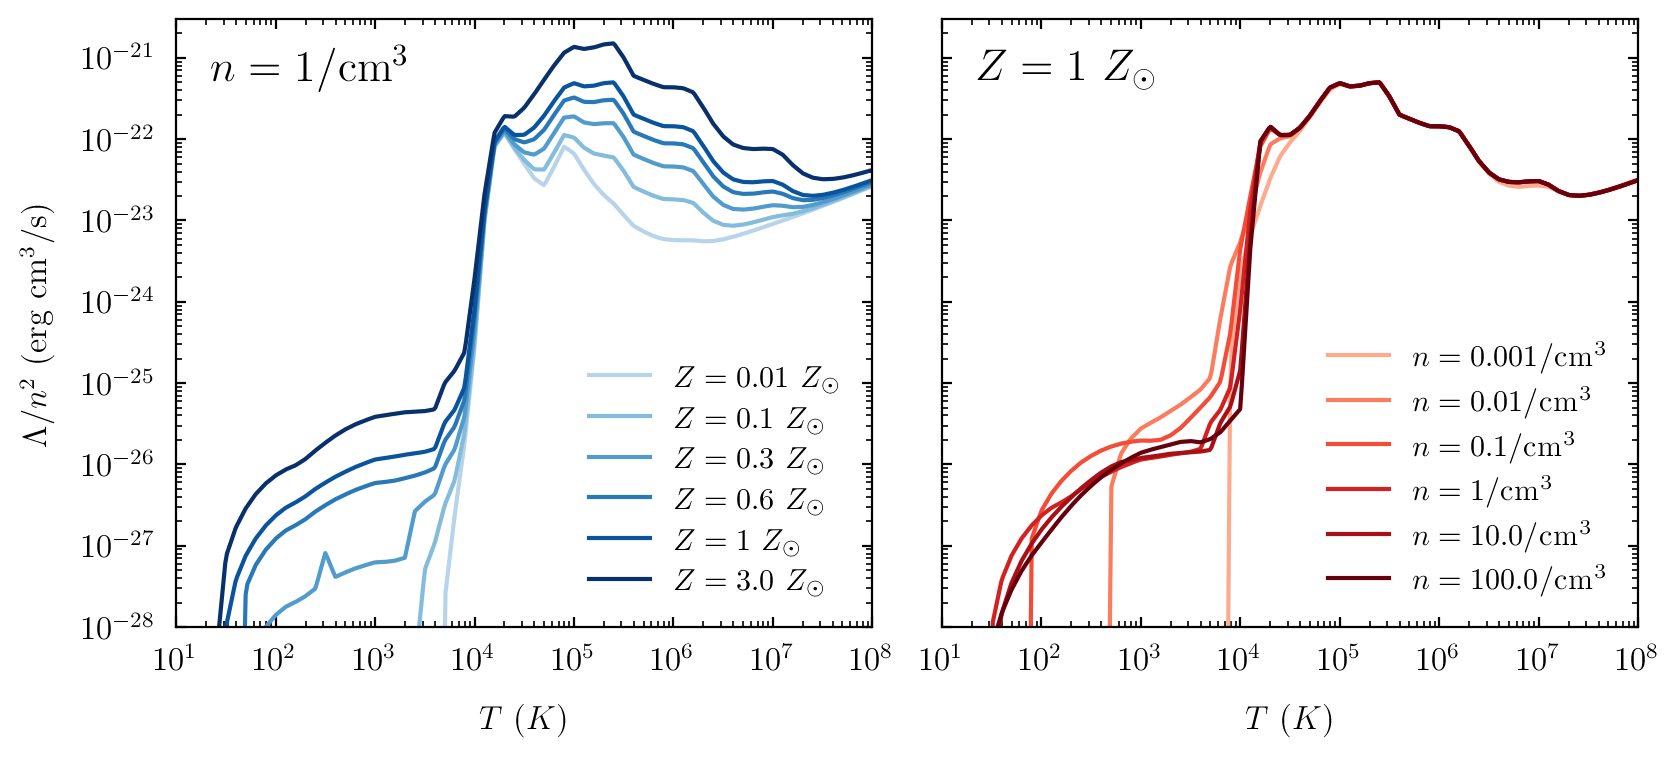

In [5]:
from routines import theory
from matplotlib.ticker import LogLocator

Z_vals = [0.01, 0.1, 0.3, 0.6, 1, 3.0]
n_vals = [0.001, 0.01, 0.1, 1, 10.0, 100.0]
Z_def = 1
n_def = 1
cmin = 0.3
cmax = 1.0
cmap_n = plt.get_cmap('Reds')
cmap_Z = plt.get_cmap('Blues')

Tmin, Tmax, nmin, nmax, _ = theory.coolingInterpolator(1.0)

fig, axs = plt.subplots(1, 2, figsize = (8.5, 4.0))
plt.subplots_adjust(left = 0.1, bottom = 0.2, right = 0.96, top = 0.96, wspace = 0.1)
for i in range(2):
    plt.sca(axs[i])
    plt.loglog()
    plt.xlabel(r'$T\ (K)$')
    if i == 0:
        plt.ylabel(r'$\Lambda/n^2\ (\rm erg\ \rm cm^3 / s)$')
    else:
        axs[i].set_yticklabels([])
    plt.xlim(1E1, 1E8)
    plt.ylim(1E-28, 3E-21)
    ax = plt.gca()
    ax.xaxis.set_major_locator(LogLocator(numticks = 100))
    ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for j in range(2):
    
    plt.sca(axs[j])
    if j == 1:
        Z = Z_def
        vals = n_vals
        cmap = cmap_n
        biglabel = r'$Z = %s\ Z_{\odot}$' % (str(Z_def))
    else:
        vals = Z_vals
        n = n_def
        cmap = cmap_Z
        biglabel = r'$n = %s/{\rm cm}^3$' % (str(n_def))
   
    for i in range(len(vals)):
        if j == 0:
            Z = vals[i]
            label = r'$Z=%s\ Z_{\odot}$' % (str(Z))
        else:
            n = vals[i]
            label = r'$n=%s/{\rm cm}^3$' % (str(n))

        if i == 0:
            log_Tmin = np.log10(Tmin)
            log_Tmax = np.log10(Tmax)
            T = 10**np.linspace(log_Tmin, log_Tmax, 500)

        Lambda = theory.coolingRate(Z, T, n)
        cval = cmin + (i / float(len(vals) - 1)) * (cmax - cmin)
        plt.plot(T, Lambda / n**2, '-', color = cmap(cval), label = label)

    plt.text(0.05, 0.9, biglabel, transform = plt.gca().transAxes, fontsize = 16)
    plt.legend(loc = 4)
plt.show()

We see that the cooling rate is approximately independent of density at high $T$, if expressed as $\Lambda / n^2$. It does significantly depend on metallicity at all temperatures.

#### 6.2.2) The cooling time

We first define a few functions we will use repeatedly in [theory.py](routines/theory.py):

Let's plot the cooling time. Since it carries a proportionality to $1 / n$, it makes sense to plot $n t_{\rm cool}$ isntead of the cooling time so that it represents the cooling time at a density of $1 / {\rm cm}^3$, which can be rescaled to other densities.

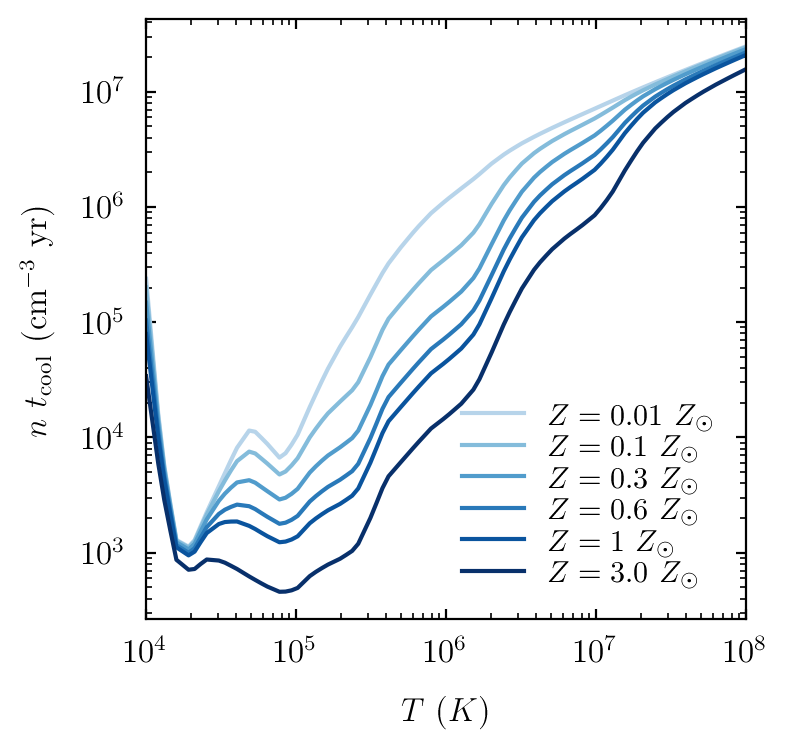

In [6]:
Tmin_plot = 1E4
Tmax_plot = 1E8
n_ref = 1.0
cmap = plt.get_cmap('Blues')

plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$T\ (K)$')
plt.ylabel(r'$n\ t_{\rm cool}\ ({\rm cm}^{-3}\ {\rm yr})$')
plt.xlim(Tmin_plot, Tmax_plot)
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

T = 10**np.linspace(np.log10(Tmin_plot), np.log10(Tmax_plot), 100)
for i in range(len(Z_vals)):
    Z = Z_vals[i]
    tcool = theory.n_tcool(Z, T, n_ref) / constants.YEAR
    cval = cmin + (i / float(len(vals) - 1)) * (cmax - cmin)
    label = r'$Z=%s\ Z_{\odot}$' % (str(Z))
    plt.plot(T, tcool, c = cmap(cval), label = label)

plt.legend(loc = 4, labelspacing = 0.1)
plt.show()

#### 6.2.3) Cooling time vs. free-fall time vs. the age of the Universe

We can also think of the cooling time of halos, once again making the (terrible) assumption that halos are uniform-density spheres. The curves change with redshift because the critical density, and thus the virial overdensity, changes. We plot curves for different redshifts but keep metallicity fixed at some small value, since we are interested in the cooling time for freshly infalling gas that should be relatively unpolluted by metals. We compare to the age of the Universe at each redshift.

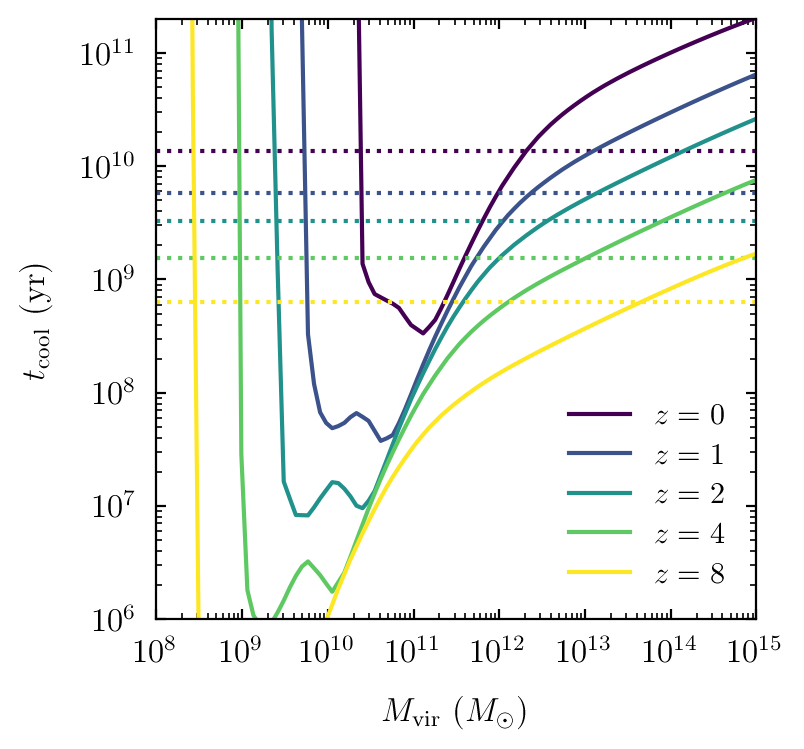

In [7]:
zs = [0, 1, 2, 4, 8]
Z = 0.001
cmap_z = plt.get_cmap('viridis')

h = cmn.cosmo.h
Mvir = 10**np.linspace(8.0, 15.0, 100)
Mvir_h = Mvir * h
tcool = np.zeros_like(Mvir)

plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$M_{\rm vir}\ (M_\odot)$')
plt.ylabel(r'$t_{\rm cool}\ ({\rm yr})$')
plt.xlim(Mvir[0], Mvir[-1])
plt.ylim(1E6, 2E11)
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i, z in enumerate(zs):
    c = cmap_z(float(i) / (len(zs) - 1))
    tH = cmn.cosmo.age(z)
    plt.axhline(tH * 1E9, ls = ':', c = c)
    tcool = theory.tcoolFromMvir(Mvir, z, Z) / constants.YEAR
    plt.plot(Mvir, tcool, label = r'$z = %s$' % str(z), c = c)
plt.legend()
plt.show()

The cooling times for large halos are longer than the age of the Universe, especially today! This indicates that cluster gas would never have time to cool (at least not in the average properties of the gaseous halo). At low mass, the curves sharply turn upwards because the virial temperature falls below the jump in the cooling curve at $T \sim 10^4\ {\rm K}$, meaning that only metal cooling contributes.

Now let's look at the ratio of cooling time to free-fall time, which tells us whether cooling is gradual or catastrophic.

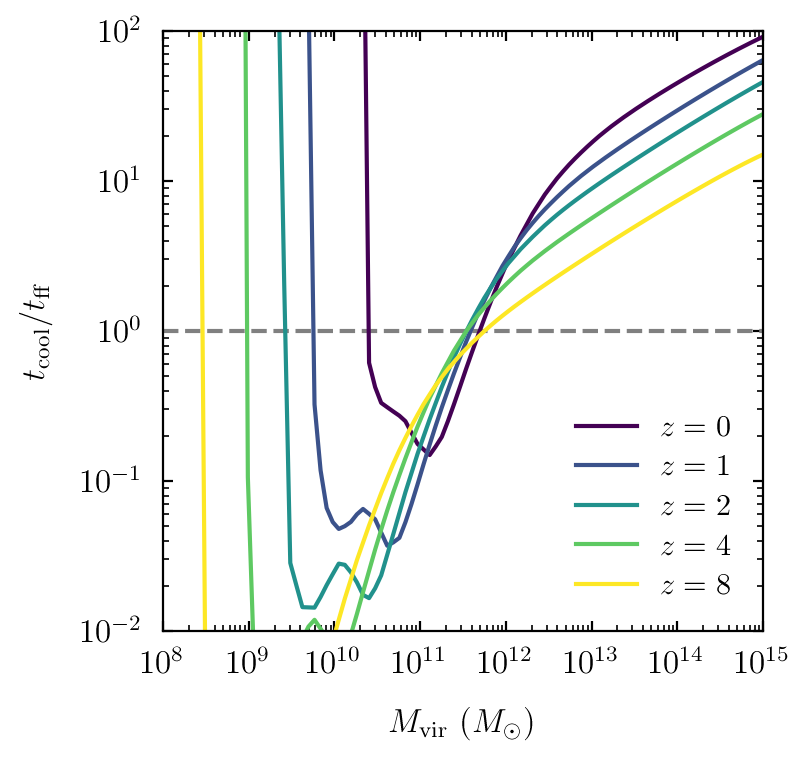

In [8]:
plt.figure(figsize = (4.0, 4.0))
plt.loglog()
plt.xlabel(r'$M_{\rm vir}\ (M_\odot)$')
plt.ylabel(r'$t_{\rm cool} / t_{\rm ff}$')
plt.xlim(Mvir[0], Mvir[-1])
plt.ylim(1E-2, 1E2)
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

plt.axhline(1.0, ls = '--', c = 'gray')
for i, z in enumerate(zs):
    c = cmap_z(float(i) / (len(zs) - 1))
    tcool = theory.tcoolFromMvir(Mvir, z, Z)
    tff = theory.tFreeFallVir(z)
    plt.plot(Mvir, tcool / tff, label = r'$z = %s$' % str(z), c = c)
plt.legend()
plt.show()

We can generalize this plot to a plane in $n$-$T$ space. The blue lines show where $t_{\rm cool} = t_{\rm ff}$ for different metallicities.

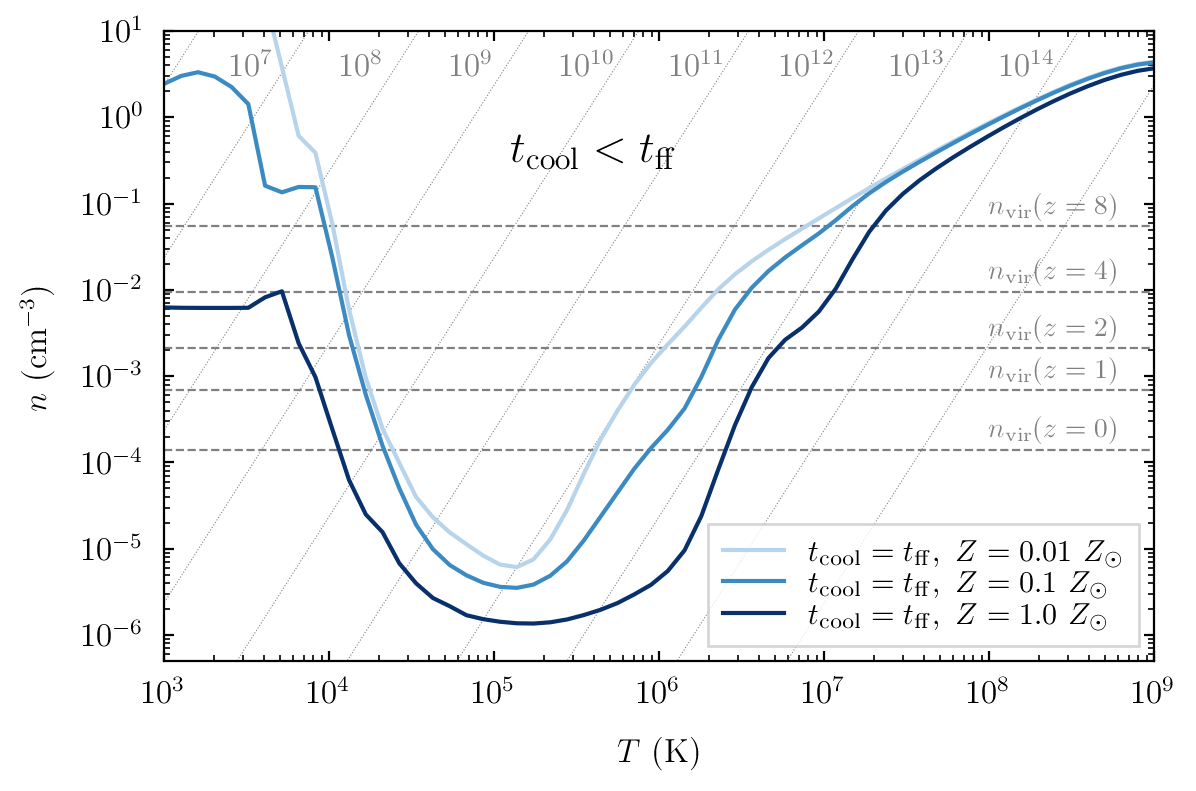

In [9]:
import scipy

Tmin_plot = 1E3
Tmax_plot = 1E9
Z_vals_ = [0.01, 0.1, 1.0]
log_M_plot = np.arange(6, 16, 1)
M_plot = 10**log_M_plot
y_max = 1E1

def eq(n, Z, T):
    
    tcool = theory.n_tcool(Z, T, n) / n
    n_tot = n / baryon_frac
    rho_tot = n_tot * mu_ion * constants.M_PROTON
    tff = theory.tFreeFall(rho_tot)
    
    return tcool - tff

T = 10**np.linspace(np.log10(Tmin_plot), np.log10(Tmax_plot), 60)
n_equal = np.zeros_like(T)

plt.figure(figsize = (6.6, 4.2))
plt.loglog()
plt.xlabel(r'$T\ ({\rm K})$')
plt.ylabel(r'$n\ ({\rm cm}^{-3})$')
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.xlim(Tmin_plot, Tmax_plot)
plt.ylim(5E-7, y_max)

# Plot lines corresponding to virial density at different redshifts
for i, z in enumerate(zs):
    rho_vir = theory.rhoVir(z)
    n_vir = rho_vir / (mu_ion * constants.M_PROTON) * baryon_frac
    plt.axhline(n_vir, ls = '--', c = 'gray', lw = 0.8)
    plt.text(Tmax_plot * 0.1, n_vir * 1.4, r'$n_{\rm vir}(z = %s)$' % str(z), transform = ax.transData, 
             color = 'gray', fontsize = 10)

# Plot lines corresponding to different halo masses. The scaling arises from the 
# dependecies of n and T on rho_vir (n ~ rho, T ~ rho^1/3) --> n ~ T^3
n0 = theory.rhoVir(0.0) / (mu_ion * constants.M_PROTON) * baryon_frac
for i, M in enumerate(M_plot):
    Tvir0 = theory.TvirFromMvir(M, 0.0)
    n_plot = n0 * (T / Tvir0)**3
    plt.plot(T, n_plot, ':', c = 'gray', lw = 0.4)
    n_text = y_max * 0.3
    T_text = (n_text / n0)**(1.0 / 3.0) * Tvir0 / 2.0
    if (T_text < Tmax_plot * 0.5) and (T_text > Tmin_plot):
        plt.text(T_text, n_text, r'$10^{%d}$' % (log_M_plot[i]), transform = ax.transData, 
                 color = 'gray', fontsize = 12)

# Plot curves where tcool = tff    
for j in range(len(Z_vals_)):
    Z = Z_vals_[j]
    mask = np.ones_like(n_equal, bool)
    for i in range(len(T)):
        args = (Z, T[i])
        if eq(nmin * 1.0001, *args) * eq(nmax * 0.999, *args) < 0.0:
            n_equal[i] = scipy.optimize.brentq(eq, nmin * 1.0001, nmax * 0.999, args = args)
        else:
            mask[i] = False
    label = r'$t_{\rm cool} = t_{\rm ff},\ Z=%s\ Z_{\odot}$' % (str(Z))
    cval = cmin + (j / float(len(Z_vals_) - 1)) * (cmax - cmin)
    plt.plot(T[mask], n_equal[mask], c = cmap(cval), label = label)

plt.text(0.35, 0.79, r'$t_{\rm cool} < t_{\rm ff}$', transform = ax.transAxes, fontsize = 16)
plt.legend(frameon = True, labelspacing = 0.1)
plt.show()

### 6.3) Reionization and a mass limit for baryon accretion

Based on simulations, [Gnedin 2000](https://ui.adsabs.harvard.edu/abs/2000ApJ...542..535G/abstract) suggested that the baryon fraction in small halos is suppressed due to reionization. He proposed the fitting function below, where the critical mass $M_{\rm C}$ is based on [Okamoto et al. 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.390..920O/abstract).

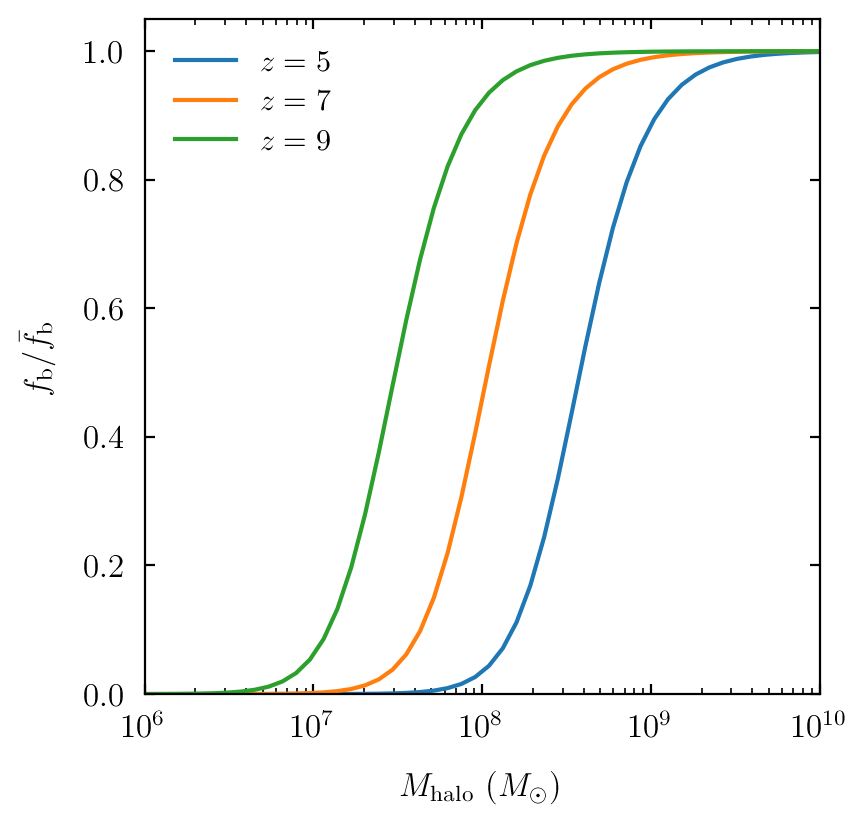

In [10]:
alpha = 2.0
h = cmn.cosmo.h
M = 10**np.linspace(6.0, 10.0, 50)

plt.figure()
plt.xscale('log')
plt.xlabel(r'$M_{\rm halo}\ (M_\odot)$')
plt.ylabel(r'$f_{\rm b} / \bar{f}_{\rm b}$')
plt.xlim(M[0], M[-1])
plt.ylim(0.0, 1.05)

for z in [5, 7, 9]:
    if z > 9.0:
        z_use = 9.0
    else:
        z_use = z
    Mc = 6E9 / h * np.exp(-0.63 * z_use)
    fb = (1.0 + (2.0**(alpha / 3) - 1) * (M / Mc)**-alpha)**(-3.0 / alpha)
    plt.plot(M, fb, label = r'$z = %s$' % (str(z)))

plt.legend()
plt.show()

We can now build a mini "model" of galaxy formation similar to [Benitez-Llambay & Frenk 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.498.4887B/abstract). We assume that there is a critical mass above which halos can cool at all, which is given by $T_{\rm vir} \sim 7000\ {\rm K}$ before reionization (the atomic hydrogen cooling limit) and by $T_{\rm vir} \sim 20000\ {\rm K}$ afterwards. We overplot three idealized halo mass accretion histories according to [Wechsler et al. 2002](https://ui.adsabs.harvard.edu/abs/2002ApJ...568...52W/abstract), $M(z) = M(0) e^{-2a_{1/2} z}$, with different formation redshifts.

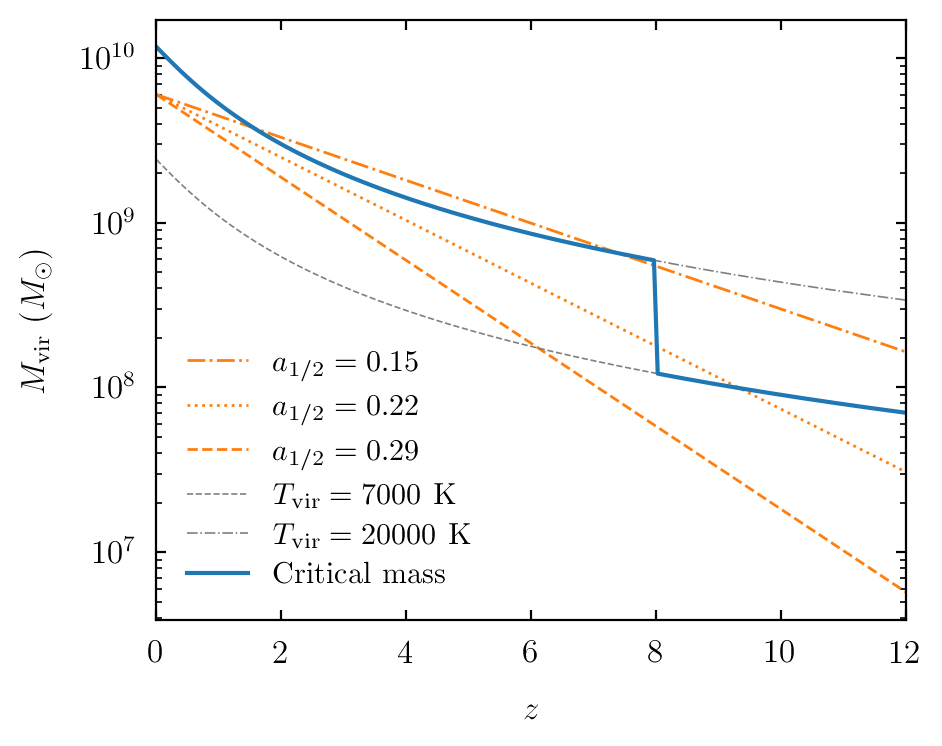

In [11]:
z = np.linspace(0.0, 12.0, 200)

plt.figure(figsize = (5.0, 4.0))
plt.yscale('log')
plt.xlabel(r'$z$')
plt.ylabel(r'$M_{\rm vir}\ (M_\odot)$')
plt.xlim(z[0], z[-1])

# Plot accretion histories
M0 = 6E9
for i, ac in enumerate([0.15, 0.22, 0.29]):
    Mz = M0 * np.exp(-2.0 * ac * z)
    plt.plot(z, Mz, color = cmn.color_cycle[1], lw = 1.0, ls = ['-.', ':', '--'][i], label = r'$a_{1/2} = %.2f$' % ac)

# Plot individual temperature-equivalent masses
Mvir_bef = theory.MvirFromTvir(7000.0, z)
plt.plot(z, Mvir_bef, color = 'gray', ls = '--', lw = 0.6, label = r'$T_{\rm vir} = 7000\ {\rm K}$')
Mvir_aft = theory.MvirFromTvir(20000.0, z)
plt.plot(z, Mvir_aft, color = 'gray', ls = '-.', lw = 0.6, label = r'$T_{\rm vir} = 20000\ {\rm K}$')

# Combine to form critical mass
Mc = np.array(Mvir_aft)
mask = (z > 8.0)
Mc[mask] = Mvir_bef[mask]
plt.plot(z, Mc, color = cmn.color_cycle[0], label = r'$\mathrm{Critical\ mass}$')

plt.legend()
plt.show()

The earliest-forming halo (dot-dashed orange lines) easily exceeds the threshold mass at almost all times and we expect it to form significant stars by $z = 0$. The second halo (dotted orange line) exceeds the threshold for only a brief time before reionization, at which point it might have produced some stars. The third halo (dashed orange line) never reaches the threshold and might well be dark at $z = 0$, even though it reaches the same total mass as the other two halos.